# Prepare for colab

In [1]:
!pip install catboost
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 165 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Upload API Token

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/backups/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


## Download and unzip dataset

In [3]:
!kaggle datasets download -d ryuina/amex-fe-plus
!unzip /content/amex-fe-plus.zip

100% 3.84G/3.85G [01:55<00:00, 57.6MB/s]
100% 3.85G/3.85G [01:55<00:00, 35.7MB/s]
Archive:  /content/amex-fe-plus.zip
  inflating: test_fe_plus_plus.parquet  
  inflating: train_fe_plus_plus.parquet  


In [4]:
!kaggle competitions download -c amex-default-prediction -f sample_submission.csv
!unzip /content/sample_submission.csv.zip

 96% 31.0M/32.4M [00:01<00:00, 27.1MB/s]
100% 32.4M/32.4M [00:01<00:00, 21.5MB/s]
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


# Settings

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from tqdm import tqdm

import os
import gc; gc.enable()

import warnings
warnings.filterwarnings('ignore')

In [6]:
VER=7
SEED = 42
FOLDS = 5

cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(SEED)

In [7]:
train = pd.read_parquet("/content/train_fe_plus_plus.parquet")
# train = train.reset_index(level=0)
test = pd.read_parquet("/content/test_fe_plus_plus.parquet")
# test = test.reset_index(level=0)

In [8]:
cat_features_last = [f"{cf}_last" for cf in cat_features]

le_encoder = LabelEncoder()
for categorical_feature in cat_features_last:
    train[categorical_feature] = le_encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = le_encoder.transform(test[categorical_feature])

In [9]:
# https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963
# Round last float features to 2 decimal place
float_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
float_cols = [col for col in float_cols if 'last' in col]

for col in float_cols:
    train[col + '_round2'] = train[col].round(2)
    test[col + '_round2'] = test[col].round(2)

num_cols = [col for col in train.columns if 'last' in col]
num_cols = [col[:-5] for col in num_cols if 'round' not in col]
for col in num_cols:
    try:
        train[f'{col}_last_mean'] = train[f'{col}_last'] - train[f'{col}_mean']
        test[f'{col}_last_mean'] = test[f'{col}_last'] - test[f'{col}_mean']

        train[f'{col}_last_min'] = train[f'{col}_last'] - train[f'{col}_min']
        test[f'{col}_last_min'] = test[f'{col}_last'] - test[f'{col}_min']

        train[f'{col}_last_max'] = train[f'{col}_last'] - train[f'{col}_max']
        test[f'{col}_last_max'] = test[f'{col}_last'] - test[f'{col}_max']

        train[f'{col}_last_s2'] = (train[f'{col}_last'] / train['S_2_lag'])
        test[f'{col}_last_s2'] = (test[f'{col}_last'] / test['S_2_lag'])
    except: pass

num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
for col in tqdm(num_cols):
    train[col] = train[col].astype(np.float16)
    test[col] = test[col].astype(np.float16)

100%|██████████| 1638/1638 [06:04<00:00,  4.49it/s]


In [10]:
train = train.set_index('customer_ID')
train = train.sort_index().reset_index()
FEATURES = train.drop(columns=['customer_ID', 'target']).columns

print(f"We have {len(FEATURES)} features!")

We have 2355 features!


In [11]:
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
# https://www.kaggle.com/code/rohanrao/amex-competition-metric-implementations
def amex_metric_np(target: np.ndarray, preds: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight * (1 / weight.sum())).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / n_pos
    
    lorentz = (target * (1 / n_pos)).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    g = gini / gini_max

    return 0.5 * (g + d)

In [12]:
cat_params = {
    'iterations':25000,
    'random_state':SEED,
    'learning_rate':0.02,

    # 'depth': 4,
    'max_depth': 7,
    "od_type": 'Iter',
    'l2_leaf_reg':70,
    # 'one_hot_max_size':20,
    # 'random_strength': 0.8,
    # 'bagging_temperature': 8,

    # 'num_leaves': 100,
    'min_child_samples': 8,

    'task_type':"GPU",
    'border_count':128,
}

In [13]:
importances = []
oof = []
gc.collect()

clf = CatBoostClassifier(**cat_params)
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(train, train.target)):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with 100% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    X_train = train.loc[train_idx, FEATURES]
    X_valid = train.target.iloc[train_idx]
    y_train = train.loc[valid_idx, FEATURES]
    y_valid = train.target.iloc[valid_idx]
    
    # TRAIN MODEL FOLD K
    model = clf.fit(X_train,
                    X_valid,
                    cat_features=cat_features_last,
                    eval_set=[(y_train, y_valid)],
                    use_best_model=True,
                    early_stopping_rounds=1500,
                    verbose_eval=1000)
    model.save_model(f'CAT_v{VER}_fold{fold}.cbm')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.feature_importances_
    df = pd.DataFrame({'feature':FEATURES,f'importance_{fold}':dd})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict_proba(y_train)[:, 1]
    acc = amex_metric_np(y_valid.values, oof_preds)
    print('Amex Metric =',acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_preds'] = oof_preds
    oof.append(df)
    
    del X_train, y_train, dd, df
    del X_valid, y_valid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_np(oof.target.values, oof.oof_preds.values)
print(f"Overall Amex metric: {acc}")

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
0:	learn: 0.6669884	test: 0.6669511	best: 0.6669511 (0)	total: 109ms	remaining: 45m 30s
1000:	learn: 0.2140508	test: 0.2205592	best: 0.2205592 (1000)	total: 1m 34s	remaining: 37m 48s
2000:	learn: 0.2071077	test: 0.2187379	best: 0.2187379 (2000)	total: 3m 5s	remaining: 35m 34s
3000:	learn: 0.2017209	test: 0.2179694	best: 0.2179694 (3000)	total: 4m 36s	remaining: 33m 43s
4000:	learn: 0.1971743	test: 0.2175397	best: 0.2175397 (3999)	total: 6m 5s	remaining: 32m
5000:	learn: 0.1927503	test: 0.2171964	best: 0.2171963 (4999)	total: 7m 36s	remaining: 30m 25s
6000:	learn: 0.1886929	test: 0.2169352	best: 0.2169352 (6000)	total: 9m 6s	remaining: 28m 50s
7000:	learn: 0.1847863	test: 0.2167137	best: 0.2167121 (6965)	total: 10m 36s	remaining: 27m 15s
8000:	learn: 0.1810301	test: 0.2165680	best: 0.2165636 (7918)	total: 12m 6s	remaining: 25m 43s
9000:	learn: 0.17738

In [14]:
del train
_ = gc.collect()

In [15]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1, numeric_only=True)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'cat_feature_importance_v{VER}.csv',index=False)

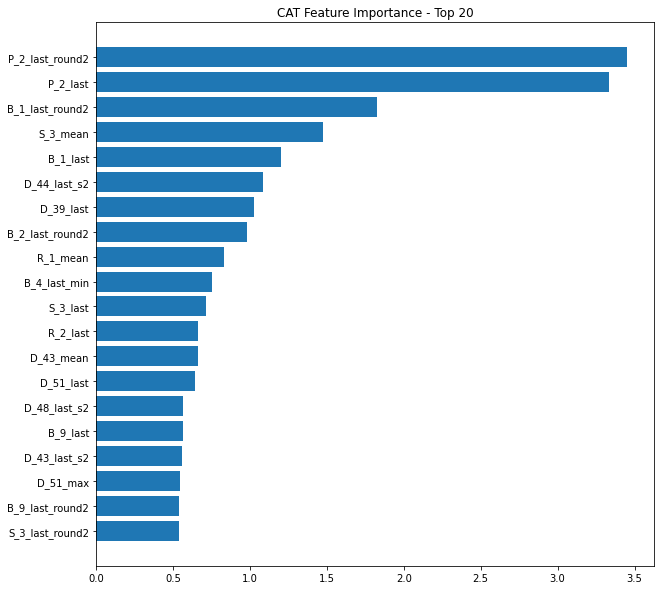

In [16]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'CAT Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Test part

In [17]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [18]:
# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4

customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[231155, 231155, 231155, 231156]


In [19]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test_copy = test.iloc[skip_rows:skip_rows+rows[k]].copy()
    test_copy = test_copy.set_index('customer_ID')
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test_copy.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    if k==NUM_PARTS-1: test_copy = test_copy.loc[customers[skip_cust:]]
    else: test_copy = test_copy.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
        
    # INFER XGB MODELS ON TEST DATA
    model = CatBoostClassifier(**cat_params)
    model.load_model(f'CAT_v{VER}_fold0.cbm')
    preds = model.predict_proba(test_copy)[:, 1]
    for f in range(1,FOLDS):
        model.load_model(f'CAT_v{VER}_fold{f}.cbm')
        preds += model.predict_proba(test_copy)[:, 1]
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del test_copy, model
    _ = gc.collect()

del test
_ = gc.collect()


Reading test data...
=> Test part 1 has shape (231155, 2355)

Reading test data...
=> Test part 2 has shape (231155, 2355)

Reading test data...
=> Test part 3 has shape (231155, 2355)

Reading test data...
=> Test part 4 has shape (231156, 2355)


# Submit

In [20]:
# WRITE SUBMISSION FILE
test = pd.DataFrame(index=customers,data={'prediction': np.concatenate(test_preds)})
sub = pd.read_csv('/content/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].copy()
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_cat_v{VER}_seed{SEED}_fold{FOLDS}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.015896
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001105
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.040877
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.211339
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.861838


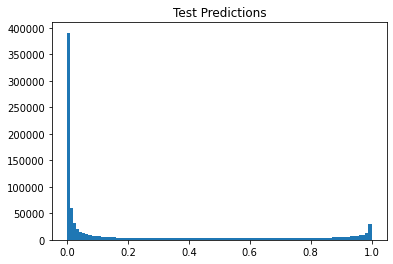

In [21]:
# PLOT PREDICTIONS
plt.hist(sub.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

# Submit to Kaggle from Colab

In [24]:
# Submit
!kaggle competitions submit -c amex-default-prediction -f submission_cat_v7_seed42_fold5.csv -m "Run with seed 42 fold 5 last / s2"

100% 75.3M/75.3M [00:09<00:00, 8.23MB/s]
Successfully submitted to American Express - Default Prediction

In [26]:
# Run after few seconds
!kaggle competitions submissions amex-default-prediction

fileName                            date                 description                                               status    publicScore  privateScore  
----------------------------------  -------------------  --------------------------------------------------------  --------  -----------  ------------  
submission_cat_v7_seed42_fold5.csv  2022-07-29 04:02:04  Run with seed 42 fold 5 last / s2                         complete  0.796                      
Amex Default Prediction - Ensemble  2022-07-28 14:38:46  Notebook Amex Default Prediction - Ensemble | Version 29  complete  0.798                      
Amex Default Prediction - Ensemble  2022-07-28 14:34:35  Notebook Amex Default Prediction - Ensemble | Version 28  complete  0.798                      
Amex Default Prediction - Ensemble  2022-07-28 13:10:11  Notebook Amex Default Prediction - Ensemble | Version 27  complete  0.798                      
submission_lgb_v1_seed42_fold5.csv  2022-07-28 12:43:40  the first version. fe lag